In [42]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

## Load data

In [43]:
def load_and_explore_data():
    """Carga todos los datasets y explora su estructura"""
    
    # Cargar datasets
    datasets = {
        'aleatorio': pd.read_csv('data/maglev_experiment_aleatorio.csv'),
        'complejo': pd.read_csv('data/maglev_experiment_complejo.csv'),
        'rampa': pd.read_csv('data/maglev_experiment_rampa.csv'),
        'seno_lento': pd.read_csv('data/maglev_experiment_seno_lento.csv'),
        'seno_rapido': pd.read_csv('data/maglev_experiment_seno_rapido.csv')
    }
    
    print("=== EXPLORACIÓN DE DATOS ===")
    for name, data in datasets.items():
        print(f"\n--- Dataset: {name} ---")
        print(f"Shape: {data.shape}")
        print(f"Columns: {data.columns.tolist()}")
        print(f"Time range: {data['time'].min():.3f} to {data['time'].max():.3f} segundos")
        print(f"Duration: {data['time'].max() - data['time'].min():.3f} segundos")
        print(f"Missing values: {data.isnull().sum().sum()}")
        
        # Estadísticas básicas
        stats = data[['position', 'velocity', 'current', 'reference', 'voltage']].describe()
        print("Estadísticas:")
        print(stats.round(4))
        
        # Verificar orden temporal
        is_sorted = data['time'].is_monotonic_increasing
        print(f"Datos ordenados temporalmente: {is_sorted}")
    
    return datasets

## Clean and Normalize data

In [44]:
def clean_and_normalize_data(datasets):
    """Limpia y normaliza todos los datasets"""
    
    print("\n=== CLEAN AND NORMALIZE DATA ===")    
    
    # Recopilar todos los datos para normalización global
    all_features_data = []
    
    # Columnas para normalizar (excluir 'time')
    feature_columns = ['position', 'velocity', 'current', 'reference', 'voltage']
    
    # Primera pasada: recopilar datos limpios
    cleaned_datasets_temp = {}
    
    for name, data in datasets.items():
        print(f"\nLimpiando {name}...")
        
        # Crear copia y limpiar
        data_clean = data.copy()
        
        # Remover valores problemáticos
        data_clean = data_clean.replace([np.inf, -np.inf], np.nan)
        initial_rows = len(data_clean)
        data_clean = data_clean.dropna()
        final_rows = len(data_clean)
        
        print(f"  Filas removidas: {initial_rows - final_rows}")
        
        # Ordenar por tiempo
        data_clean = data_clean.sort_values('time').reset_index(drop=True)
        
        # Verificar continuidad temporal (detectar saltos grandes)
        time_diffs = np.diff(data_clean['time'])
        median_dt = np.median(time_diffs)
        large_gaps = np.where(time_diffs > 5 * median_dt)[0]
        
        if len(large_gaps) > 0:
            print(f"  ⚠️  Advertencia: {len(large_gaps)} saltos grandes en tiempo detectados")
        
        print(f"  Datos finales: {final_rows} filas")
        print(f"  Frecuencia de muestreo promedio: {1/median_dt:.1f} Hz")
        
        cleaned_datasets_temp[name] = data_clean
        
        # Recopilar features para normalización global
        all_features_data.append(data_clean[feature_columns].values)
    
    # Concatenar todos los datos para crear scaler global
    all_features_combined = np.vstack(all_features_data)
    
    print(f"\nCreando scaler global con {all_features_combined.shape[0]} muestras...")
    
    # Crear y ajustar scaler global
    global_scaler = StandardScaler()
    global_scaler.fit(all_features_combined)
    
    # Mostrar estadísticas del scaler
    print("Medias por feature:", global_scaler.mean_.round(4))
    print("Desviaciones estándar:", global_scaler.scale_.round(4))
    
    # Segunda pasada: aplicar normalización
    cleaned_datasets = {}
    
    for name, data_clean in cleaned_datasets_temp.items():
        # Aplicar normalización
        normalized_features = global_scaler.transform(data_clean[feature_columns])
        
        # Reconstruir DataFrame
        result = pd.DataFrame(normalized_features, columns=feature_columns)
        result.insert(0, 'time', data_clean['time'].values)
        
        cleaned_datasets[name] = result
        
        print(f"Dataset {name} normalizado: {result.shape}")
    
    return cleaned_datasets, global_scaler

## Create Control Sequence

In [45]:
def create_control_sequences(data, seq_length=30, predict_steps_ahead=1):
    """
    Crea secuencias para entrenar el controlador
    
    INPUT: [position, velocity, current, reference] - Estado + referencia
    OUTPUT: voltage - Señal de control
    """
    sequences = []
    targets = []
    times = []
    
    # Features de entrada: estado del sistema + referencia
    input_features = ['position', 'velocity', 'current', 'reference']
    target_feature = 'voltage'  # Señal de control
    
    for i in range(len(data) - seq_length - predict_steps_ahead + 1):
        # Secuencia de entrada: historial del estado
        seq = data[input_features].iloc[i:i+seq_length].values
        
        # Target: voltaje de control futuro
        target = data[target_feature].iloc[i+seq_length+predict_steps_ahead-1]
        
        # Tiempo correspondiente (para debugging)
        time_point = data['time'].iloc[i+seq_length+predict_steps_ahead-1]
        
        sequences.append(seq)
        targets.append(target)
        times.append(time_point)
    
    return np.array(sequences), np.array(targets), np.array(times)

def process_all_sequences(cleaned_datasets, seq_length=30):
    """Procesa todos los datasets para crear secuencias de control"""
    
    print(f"\n=== CREACIÓN DE SECUENCIAS DE CONTROL ===")
    print(f"Longitud de secuencia: {seq_length}")
    print(f"Input features: [position, velocity, current, reference]")
    print(f"Target: voltage (señal de control)")
    
    all_sequences = []
    all_targets = []
    all_times = []
    sequence_info = []
    
    for name, data in cleaned_datasets.items():
        print(f"\nProcesando {name}...")
        
        sequences, targets, times = create_control_sequences(data, seq_length)
        
        print(f"  Secuencias creadas: {sequences.shape}")
        print(f"  Targets: {targets.shape}")
        print(f"  Rango temporal: {times.min():.2f} to {times.max():.2f}")
        
        # Verificar que no hay NaN
        if np.isnan(sequences).any() or np.isnan(targets).any():
            print(f"  ⚠️  Advertencia: NaN detectados en {name}")
        
        all_sequences.append(sequences)
        all_targets.append(targets)
        all_times.append(times)
        sequence_info.append((name, len(sequences)))
    
    # Concatenar todo
    X_all = np.concatenate(all_sequences, axis=0)
    y_all = np.concatenate(all_targets, axis=0)
    times_all = np.concatenate(all_times, axis=0)
    
    print(f"\n=== RESUMEN DE SECUENCIAS ===")
    print(f"Total secuencias: {X_all.shape[0]}")
    print(f"Shape de entrada X: {X_all.shape}")  # (samples, seq_length, 4)
    print(f"Shape de salida y: {y_all.shape}")   # (samples,)
    print(f"Distribución por experimento:")
    for name, count in sequence_info:
        percentage = (count / X_all.shape[0]) * 100
        print(f"  {name}: {count} ({percentage:.1f}%)")
    
    return X_all, y_all, times_all, sequence_info

## Split data into train and test

In [46]:
def split_control_data(cleaned_datasets, seq_length=30, test_experiments=['aleatorio']):
    """
    Divide los datos para entrenamiento de controlador
    
    Estrategia:
    - Experimentos especificados van completos a test
    - Resto se divide temporalmente: 75% train, 15% val, 10% test
    """
    
    print(f"\n=== DIVISIÓN DE DATOS ===")
    print(f"Experimentos para test: {test_experiments}")
    
    train_X, train_y = [], []
    val_X, val_y = [], []
    test_X, test_y = [], []
    
    split_info = {}
    
    for name, data in cleaned_datasets.items():
        sequences, targets, _ = create_control_sequences(data, seq_length)
        
        if name in test_experiments:
            # Experimento completo para test
            test_X.append(sequences)
            test_y.append(targets)
            split_info[name] = {'train': 0, 'val': 0, 'test': len(sequences)}
            print(f"{name} -> TEST completo: {sequences.shape[0]} samples")
            
        else:
            # División temporal
            n_samples = len(sequences)
            train_end = int(0.75 * n_samples)
            val_end = int(0.9 * n_samples)
            
            # Train: primeros 75%
            train_X.append(sequences[:train_end])
            train_y.append(targets[:train_end])
            
            # Validation: siguientes 15%
            val_X.append(sequences[train_end:val_end])
            val_y.append(targets[train_end:val_end])
            
            # Test: últimos 10%
            test_X.append(sequences[val_end:])
            test_y.append(targets[val_end:])
            
            split_info[name] = {
                'train': train_end,
                'val': val_end - train_end,
                'test': n_samples - val_end
            }
            
            print(f"{name} -> Train: {train_end}, Val: {val_end-train_end}, Test: {n_samples-val_end}")
    
    # Concatenar
    X_train = np.concatenate(train_X) if train_X else np.array([])
    y_train = np.concatenate(train_y) if train_y else np.array([])
    X_val = np.concatenate(val_X) if val_X else np.array([])
    y_val = np.concatenate(val_y) if val_y else np.array([])
    X_test = np.concatenate(test_X) if test_X else np.array([])
    y_test = np.concatenate(test_y) if test_y else np.array([])
    
    print(f"\n=== DIVISIÓN FINAL ===")
    print(f"Training: {X_train.shape[0]} samples ({X_train.shape})")
    print(f"Validation: {X_val.shape[0]} samples ({X_val.shape})")
    print(f"Test: {X_test.shape[0]} samples ({X_test.shape})")
    
    # Verificar distribución
    total_samples = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
    print(f"Distribución: Train {X_train.shape[0]/total_samples:.1%}, "
          f"Val {X_val.shape[0]/total_samples:.1%}, "
          f"Test {X_test.shape[0]/total_samples:.1%}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, split_info


## Pytorch Tensor

In [47]:
def create_pytorch_tensors(X_train, y_train, X_val, y_val, X_test, y_test):
    """Convierte arrays numpy a tensores PyTorch"""
    
    print(f"\n=== CONVERSIÓN A TENSORES PYTORCH ===")
    
    # Convertir a tensores
    tensors = {
        'X_train': torch.FloatTensor(X_train),
        'y_train': torch.FloatTensor(y_train),
        'X_val': torch.FloatTensor(X_val),
        'y_val': torch.FloatTensor(y_val),
        'X_test': torch.FloatTensor(X_test),
        'y_test': torch.FloatTensor(y_test)
    }
    
    # Verificar shapes
    for name, tensor in tensors.items():
        print(f"{name}: {tensor.shape}, dtype: {tensor.dtype}")
    
    # Verificar que no hay NaN o infinitos
    for name, tensor in tensors.items():
        if torch.isnan(tensor).any():
            print(f"⚠️  Advertencia: NaN encontrados en {name}")
        if torch.isinf(tensor).any():
            print(f"⚠️  Advertencia: Infinitos encontrados en {name}")
    
    return tensors

def create_data_loaders(tensors, batch_size=32, shuffle_train=True):
    """Crea DataLoaders para entrenamiento"""
    
    print(f"\n=== CREACIÓN DE DATALOADERS ===")
    print(f"Batch size: {batch_size}")
    
    # Crear datasets
    train_dataset = TensorDataset(tensors['X_train'], tensors['y_train'])
    val_dataset = TensorDataset(tensors['X_val'], tensors['y_val'])
    test_dataset = TensorDataset(tensors['X_test'], tensors['y_test'])
    
    # Crear DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train loader: {len(train_loader)} batches")
    print(f"Val loader: {len(val_loader)} batches")
    print(f"Test loader: {len(test_loader)} batches")
    
    return train_loader, val_loader, test_loader

## Visualize data

In [48]:
def visualize_processed_data(cleaned_datasets, sequence_info):
    """Visualiza los datos procesados"""
    
    print(f"\n=== VISUALIZACIÓN DE DATOS PROCESADOS ===")
    
    # Configurar subplots
    n_datasets = len(cleaned_datasets)
    fig, axes = plt.subplots(n_datasets, 1, figsize=(15, 3*n_datasets))
    if n_datasets == 1:
        axes = [axes]
    
    for i, (name, data) in enumerate(cleaned_datasets.items()):
        ax = axes[i]
        
        # Plotear señales principales
        time_vals = data['time'].values
        ax.plot(time_vals, data['position'], label='Position', alpha=0.8, linewidth=1)
        ax.plot(time_vals, data['reference'], label='Reference', alpha=0.8, linewidth=1, linestyle='--')
        ax.plot(time_vals, data['voltage'], label='Voltage (Control)', alpha=0.7, linewidth=1)
        
        ax.set_title(f'Experimento: {name}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Normalized Values')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Añadir info de secuencias
        seq_count = next((count for exp_name, count in sequence_info if exp_name == name), 0)
        ax.text(0.02, 0.98, f'Secuencias: {seq_count}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Histogramas de distribución
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    # Combinar todos los datos para histogramas
    all_data = pd.concat(cleaned_datasets.values(), ignore_index=True)
    
    features_to_plot = ['position', 'velocity', 'voltage', 'current']
    for i, feature in enumerate(features_to_plot):
        axes[i].hist(all_data[feature], bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribución de {feature}')
        axes[i].set_xlabel('Valor normalizado')
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Main Function

In [49]:
def preprocess_maglev_data(seq_length=30, batch_size=32, test_experiments=['aleatorio']):
    """
    Función principal que ejecuta todo el pipeline de preprocesamiento
    
    Args:
        seq_length: Longitud de las secuencias temporales
        batch_size: Tamaño de batch para DataLoaders
        test_experiments: Lista de experimentos para usar solo en test
    
    Returns:
        dict con todos los datos procesados
    """
    
    print("🚀 INICIANDO PREPROCESAMIENTO DE DATOS PARA CONTROLADOR MAGNÉTICO")
    print("="*70)
    
    # Paso 1: Cargar datos
    datasets = load_and_explore_data()
    
    # Paso 2: Limpiar y normalizar
    cleaned_datasets, scaler = clean_and_normalize_data(datasets)
    
    # Paso 3: Crear secuencias
    X_all, y_all, times_all, sequence_info = process_all_sequences(cleaned_datasets, seq_length)
    
    # Paso 4: Dividir datos
    X_train, y_train, X_val, y_val, X_test, y_test, split_info = split_control_data(
        cleaned_datasets, seq_length, test_experiments
    )
    
    # Paso 5: Crear tensores
    tensors = create_pytorch_tensors(X_train, y_train, X_val, y_val, X_test, y_test)
    
    # Paso 6: Crear DataLoaders
    train_loader, val_loader, test_loader = create_data_loaders(tensors, batch_size)
    
    # Paso 7: Visualizar
    visualize_processed_data(cleaned_datasets, sequence_info)
    
    # Preparar resultado
    result = {
        'tensors': tensors,
        'data_loaders': (train_loader, val_loader, test_loader),
        'scaler': scaler,
        'sequence_info': sequence_info,
        'split_info': split_info,
        'config': {
            'seq_length': seq_length,
            'batch_size': batch_size,
            'input_features': ['position', 'velocity', 'current', 'reference'],
            'target_feature': 'voltage',
            'input_size': 4,
            'output_size': 1
        }
    }
    
    print("\n" + "="*70)
    print("✅ PREPROCESAMIENTO COMPLETADO")
    print("="*70)
    print(f"📊 Total de secuencias de entrenamiento: {X_train.shape[0]}")
    print(f"📈 Input shape: {X_train.shape}")
    print(f"🎯 Target: voltage (señal de control)")
    print(f"⚙️  Configuración lista para entrenar RNN controlador")
    
    return result

## Save data

In [50]:
def save_processed_data(result, filename='processed_maglev_controller_data.pth'):
    """Guarda todos los datos procesados"""
    
    # Crear directorio si no existe
    os.makedirs('processed_data', exist_ok=True)
    filepath = os.path.join('processed_data', filename)
    
    # Guardar
    torch.save(result, filepath)
    print(f"\n💾 Datos guardados en: {filepath}")
    
    return filepath

def load_processed_data(filename='processed_maglev_controller_data.pth'):
    """Carga datos previamente procesados"""
    
    filepath = os.path.join('processed_data', filename)
    result = torch.load(filepath, weights_only=False)
    print(f"📂 Datos cargados desde: {filepath}")
    
    return result

🚀 INICIANDO PREPROCESAMIENTO DE DATOS PARA CONTROLADOR MAGNÉTICO
=== EXPLORACIÓN DE DATOS ===

--- Dataset: aleatorio ---
Shape: (6001, 6)
Columns: ['time', 'position', 'velocity', 'current', 'reference', 'voltage']
Time range: 0.000 to 60.000 segundos
Duration: 60.000 segundos
Missing values: 0
Estadísticas:
        position   velocity    current  reference    voltage
count  6001.0000  6001.0000  6001.0000  6001.0000  6001.0000
mean      0.0063    -0.0001    -0.0736     0.0063    -0.7407
std       0.0033     0.0079     0.3329     0.0033     3.3866
min       0.0012    -0.0709    -0.7459     0.0012   -17.2460
25%       0.0032    -0.0000    -0.3840     0.0032    -3.8399
50%       0.0061    -0.0000    -0.0912     0.0062    -0.9244
75%       0.0083     0.0000     0.1357     0.0083     1.3566
max       0.0126     0.0979     0.5935     0.0126    11.5267
Datos ordenados temporalmente: True

--- Dataset: complejo ---
Shape: (6001, 6)
Columns: ['time', 'position', 'velocity', 'current', 'refere

/home/mgalindo/max/projects/maglev/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mgalindo/max/projects/maglev/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mgalindo/max/projects/maglev/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mgalindo/max/projects/maglev/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/mgalindo/max/projects/maglev/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted with

  Secuencias creadas: (5971, 30, 4)
  Targets: (5971,)
  Rango temporal: 0.30 to 60.00

Procesando complejo...
  Secuencias creadas: (5971, 30, 4)
  Targets: (5971,)
  Rango temporal: 0.30 to 60.00

Procesando rampa...
  Secuencias creadas: (5971, 30, 4)
  Targets: (5971,)
  Rango temporal: 0.30 to 60.00

Procesando seno_lento...
  Secuencias creadas: (5971, 30, 4)
  Targets: (5971,)
  Rango temporal: 0.30 to 60.00

Procesando seno_rapido...
  Secuencias creadas: (5971, 30, 4)
  Targets: (5971,)
  Rango temporal: 0.30 to 60.00

=== RESUMEN DE SECUENCIAS ===
Total secuencias: 29855
Shape de entrada X: (29855, 30, 4)
Shape de salida y: (29855,)
Distribución por experimento:
  aleatorio: 5971 (20.0%)
  complejo: 5971 (20.0%)
  rampa: 5971 (20.0%)
  seno_lento: 5971 (20.0%)
  seno_rapido: 5971 (20.0%)

=== DIVISIÓN DE DATOS ===
Experimentos para test: ['aleatorio']
aleatorio -> TEST completo: 5971 samples
complejo -> Train: 4478, Val: 895, Test: 598
rampa -> Train: 4478, Val: 895, Test: 59

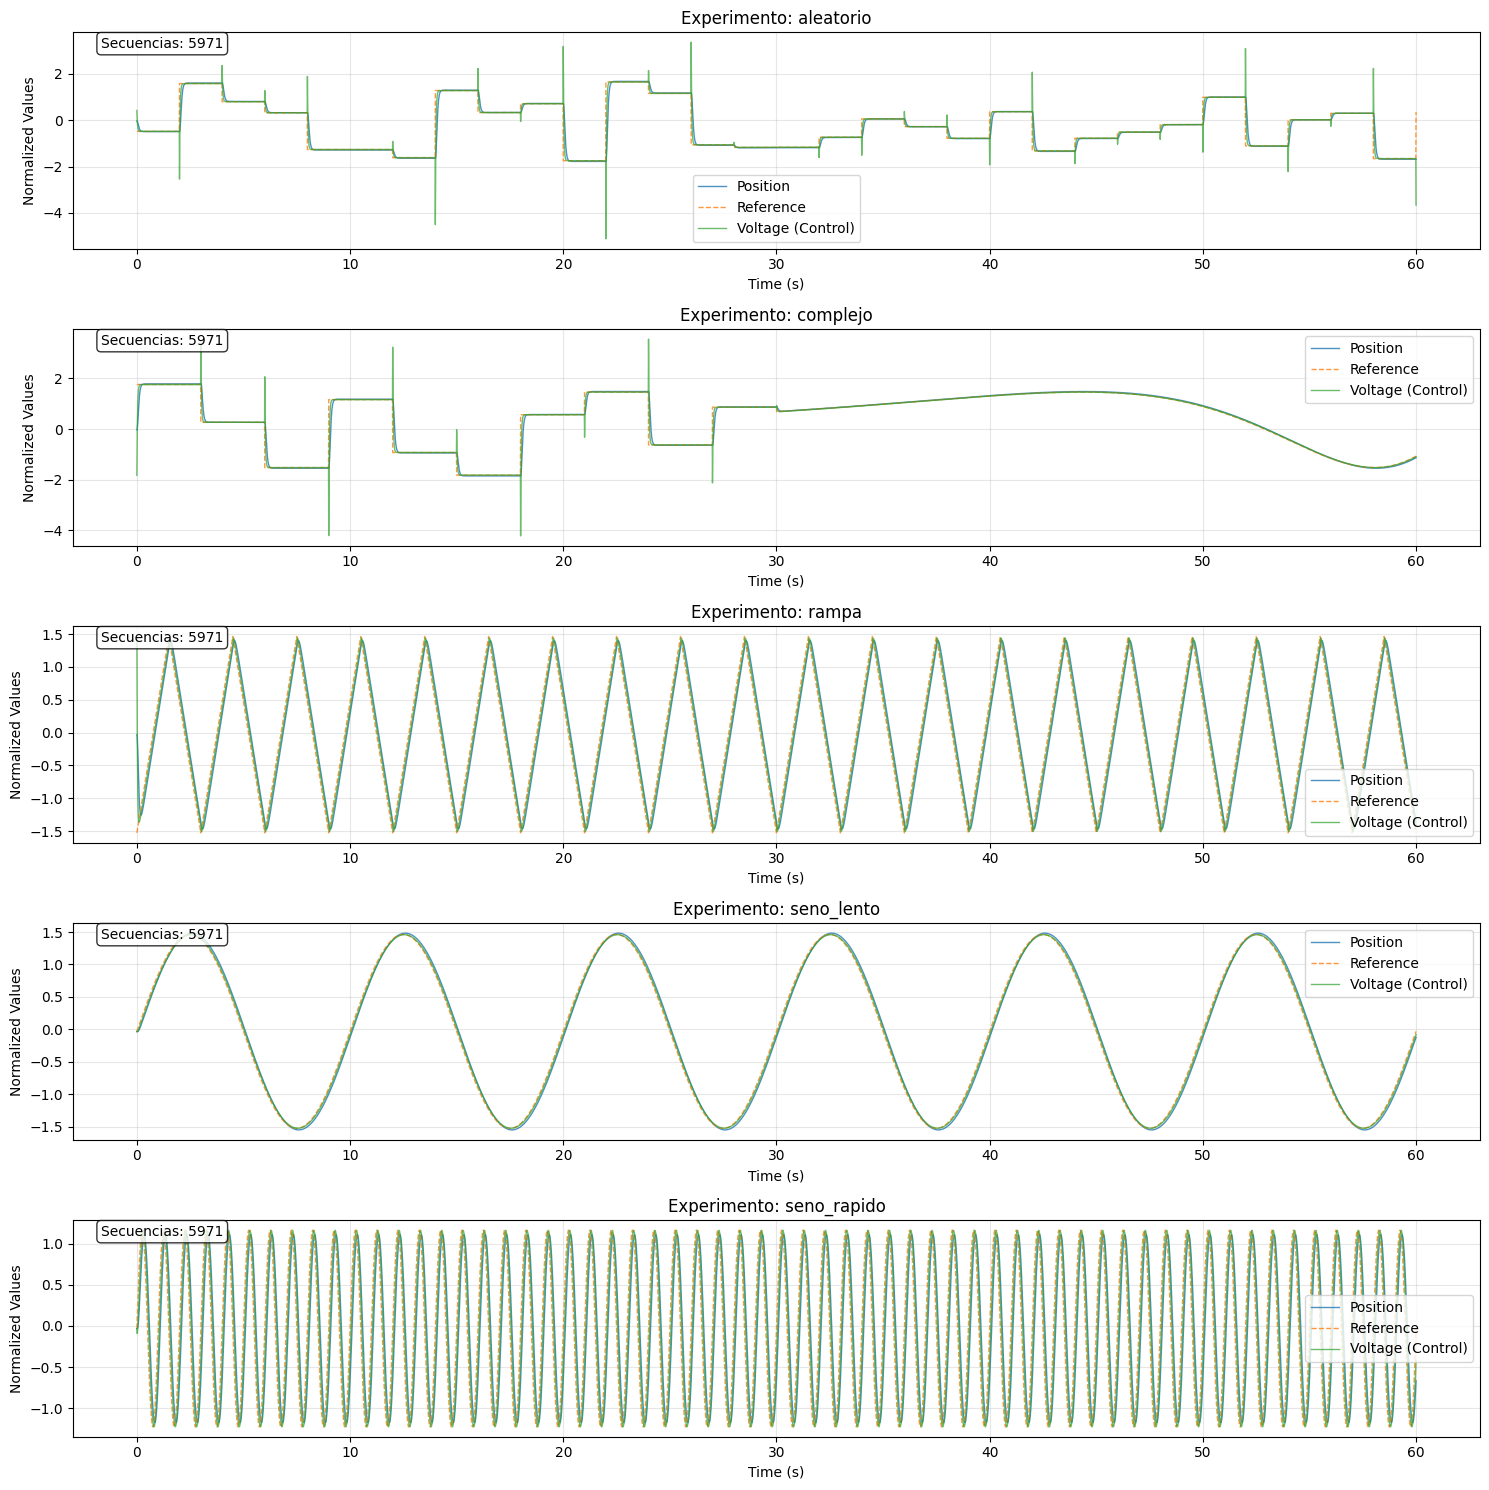

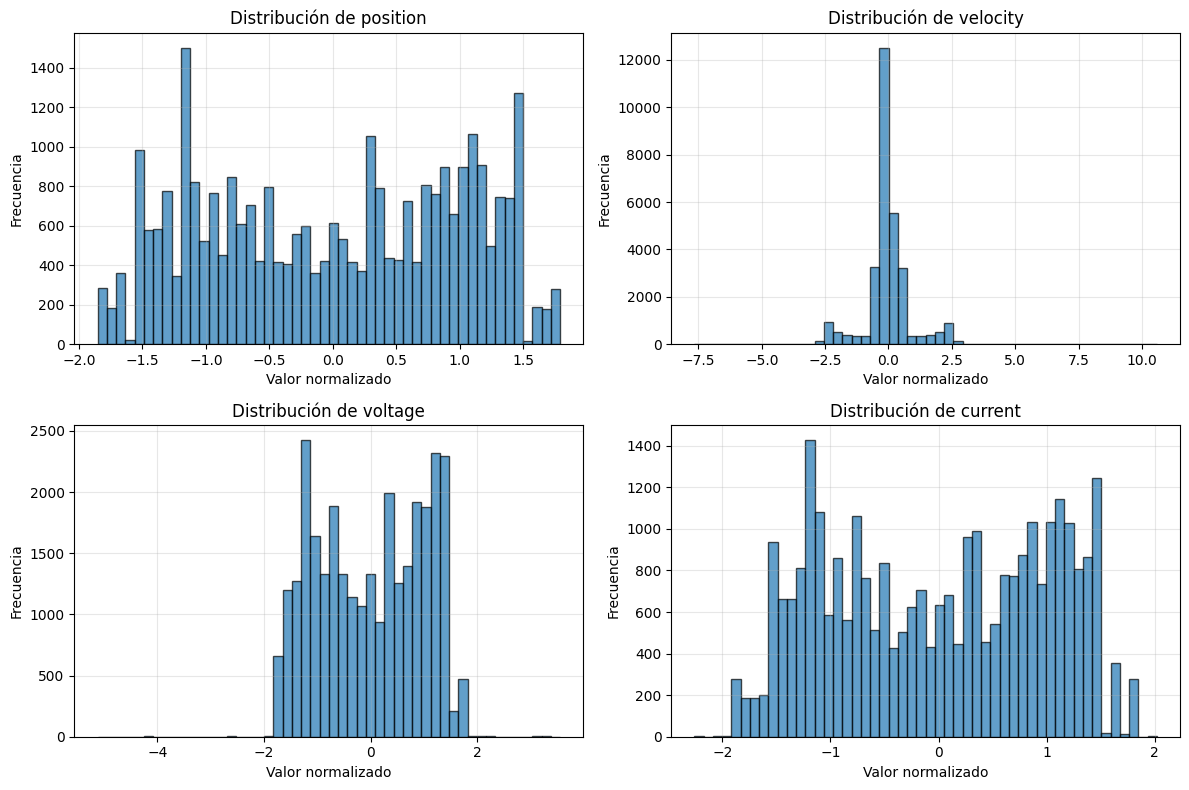


✅ PREPROCESAMIENTO COMPLETADO
📊 Total de secuencias de entrenamiento: 17912
📈 Input shape: (17912, 30, 4)
🎯 Target: voltage (señal de control)
⚙️  Configuración lista para entrenar RNN controlador

💾 Datos guardados en: processed_data/processed_maglev_controller_data.pth


'processed_data/processed_maglev_controller_data.pth'

In [51]:
processed_data = preprocess_maglev_data(
        seq_length=30,           # Longitud de secuencia temporal
        batch_size=32,           # Batch size para entrenamiento
        test_experiments=['aleatorio']  # Experimentos para test
    )
    
    # Guardar datos procesados
save_processed_data(processed_data)

## RRN MODEL

In [ ]:

import torch.nn as nn

class MaglevControlRNN(nn.Module):
    """
    RNN para control de levitador magnético
    
    Input: [position, velocity, current, reference] en secuencias temporales
    Output: voltage (señal de control)
    """
    
    def __init__(self, input_size=4, hidden_size=64, num_layers=2, 
                 output_size=1, dropout=0.2, rnn_type='LSTM'):
        super(MaglevControlRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        # Capa RNN principal
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size, hidden_size, num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0,
                bidirectional=False
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size, hidden_size, num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0,
                bidirectional=False
            )
        else:
            raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")
        
        # Capas densas para generar señal de control
        self.controller = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.Tanh(),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_size // 4, output_size)
        )
        
        # Inicialización de pesos
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Inicialización específica para control"""
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                # Pesos input-hidden: Xavier
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                # Pesos hidden-hidden: Ortogonal
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                # Bias: cero con forget gate bias = 1 para LSTM
                param.data.fill_(0)
                if 'LSTM' in str(type(self.rnn)):
                    # Set forget gate bias to 1
                    n = param.size(0)
                    param.data[n//4:n//2].fill_(1)
            elif 'controller' in name and 'weight' in name:
                # Capas densas: He initialization
                nn.init.kaiming_uniform_(param.data, nonlinearity='relu')
    
    def forward(self, x, hidden=None):
        """
        Forward pass
        
        Args:
            x: (batch_size, seq_len, input_size) - Secuencias de estado
            hidden: Estado oculto inicial (opcional)
        
        Returns:
            voltage: (batch_size, output_size) - Señal de control
            hidden: Estado oculto final
        """
        # RNN principal
        rnn_out, hidden = self.rnn(x, hidden)
        
        # Tomar última salida temporal para control
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Generar señal de control
        voltage = self.controller(last_output)
        
        return voltage, hidden
    
    

## Loss

In [80]:
import torch.nn.functional as F

class ControlLoss(nn.Module):
    """
    Función de pérdida específica para control magnético
    Combina MSE con regularización para estabilidad
    """
    
    def __init__(self, mse_weight=1.0, smooth_weight=0.1, saturation_weight=0.05):
        super(ControlLoss, self).__init__()
        self.mse_weight = mse_weight
        self.smooth_weight = smooth_weight
        self.saturation_weight = saturation_weight
        
    def forward(self, predicted_voltage, target_voltage):
        # Pérdida principal: MSE
        mse_loss = F.mse_loss(predicted_voltage, target_voltage)
        
        # Penalización por cambios bruscos (suavidad temporal)
        if predicted_voltage.size(0) > 1:
            smooth_loss = torch.mean(torch.diff(predicted_voltage.squeeze(), dim=0) ** 2)
        else:
            smooth_loss = torch.tensor(0.0, device=predicted_voltage.device)
        
        # Penalización por saturación (valores extremos)
        saturation_loss = torch.mean(torch.relu(torch.abs(predicted_voltage) - 3.0) ** 2)
        
        # Combinar pérdidas
        total_loss = (self.mse_weight * mse_loss + 
                     self.smooth_weight * smooth_loss + 
                     self.saturation_weight * saturation_loss)
        
        return total_loss, {
            'mse': mse_loss.item(),
            'smooth': smooth_loss.item(),
            'saturation': saturation_loss.item(),
            'total': total_loss.item()
        }
        
    def get_model_info(self):
        """Información del modelo"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            
        return {
            'type': f'{self.rnn_type} Controller',
            'input_size': self.input_size,
            'hidden_size': self.hidden_size,
            'num_layers': self.num_layers,
            'total_params': total_params,
            'trainable_params': trainable_params
        }
        
        
def load_rnn_controller(model_path='models/maglev_controller_best.pth', 
                       data_path='processed_data/processed_maglev_controller_data.pth',
                       device='cpu'):
        """
        Carga el modelo RNN entrenado y el scaler
        """
        
        print("🔧 Cargando controlador RNN entrenado...")
        
        # Cargar datos procesados (contiene el scaler)
        try:
            processed_data = torch.load(data_path, map_location=device, weights_only=False)
            scaler = processed_data['scaler']
            config = processed_data['config']
            print(f"✅ Scaler cargado: {config['input_features']} → {config['target_feature']}")
            print(f"   Media del scaler: {scaler.mean_}")
            print(f"   Escala del scaler: {scaler.scale_}")
        except Exception as e:
            print(f"❌ Error cargando scaler: {e}")
            return None, None
        
        # Cargar modelo entrenado
        try:
            checkpoint = torch.load(model_path, map_location=device, weights_only=False)
            
            # Crear modelo con la misma arquitectura
            model = MaglevControlRNN(
                input_size=4,
                hidden_size=64,
                num_layers=2,
                output_size=1,
                dropout=0.2,
                rnn_type='LSTM'
            )
            
            # Cargar pesos
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            model.to(device)
            
            print(f"✅ Modelo RNN cargado desde época {checkpoint['epoch']}")
            print(f"   Mejor val loss: {checkpoint['val_loss']:.6f}")
            
        except Exception as e:
            print(f"❌ Error cargando modelo: {e}")
            return None, None
        
        return model, scaler

## Trainer

In [81]:
import torch.optim as optim
from collections import defaultdict
import time

class MaglevTrainer:
    """Clase para entrenar el controlador RNN"""
    
    def __init__(self, model, train_loader, val_loader, device='cpu'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Configuración de entrenamiento
        self.criterion = ControlLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.7, patience=10
        )
        
        # Tracking
        self.history = defaultdict(list)
        self.best_val_loss = float('inf')
        self.best_model_state = None
        
    def train_epoch(self):
        """Entrena una época"""
        self.model.train()
        epoch_losses = defaultdict(list)
        
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            output, _ = self.model(data)
            
            # Calcular pérdida
            loss, loss_components = self.criterion(output.squeeze(), target)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            # Tracking
            for key, value in loss_components.items():
                epoch_losses[key].append(value)
            
            # Log progreso
            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}/{len(self.train_loader)}, '
                      f'Loss: {loss.item():.6f}')
        
        # Promedios de la época
        return {key: np.mean(values) for key, values in epoch_losses.items()}
    
    def validate(self):
        """Validación"""
        self.model.eval()
        val_losses = defaultdict(list)
        predictions = []
        targets = []
        
        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                output, _ = self.model(data)
                loss, loss_components = self.criterion(output.squeeze(), target)
                
                for key, value in loss_components.items():
                    val_losses[key].append(value)
                
                predictions.append(output.cpu().numpy())
                targets.append(target.cpu().numpy())
        
        # Concatenar predicciones
        predictions = np.concatenate(predictions, axis=0)
        targets = np.concatenate(targets, axis=0)
        
        # Métricas adicionales
        mae = np.mean(np.abs(predictions.squeeze() - targets))
        rmse = np.sqrt(np.mean((predictions.squeeze() - targets) ** 2))
        
        val_metrics = {key: np.mean(values) for key, values in val_losses.items()}
        val_metrics.update({'mae': mae, 'rmse': rmse})
        
        return val_metrics, predictions, targets
    
    def train(self, num_epochs=100, save_best=True, save_dir='models'):
        """Entrenamiento completo"""
        
        print(f"🚀 Iniciando entrenamiento del controlador RNN")
        print(f"📊 Modelo: {self.model.get_model_info()}")
        print(f"💾 Dispositivo: {self.device}")
        print(f"📈 Épocas: {num_epochs}")
        print("="*60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Entrenamiento
            train_metrics = self.train_epoch()
            
            # Validación
            val_metrics, val_pred, val_true = self.validate()
            
            # Scheduler
            self.scheduler.step(val_metrics['total'])
            
            # Guardar mejor modelo
            if val_metrics['total'] < self.best_val_loss:
                self.best_val_loss = val_metrics['total']
                if save_best:
                    self.best_model_state = {
                        'epoch': epoch,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'val_loss': val_metrics['total'],
                        'train_loss': train_metrics['total']
                    }
            
            # Guardar métricas
            for key, value in train_metrics.items():
                self.history[f'train_{key}'].append(value)
            for key, value in val_metrics.items():
                self.history[f'val_{key}'].append(value)
            
            # Log época
            epoch_time = time.time() - epoch_start
            print(f"Época {epoch+1:3d}/{num_epochs} | "
                  f"Train Loss: {train_metrics['total']:.6f} | "
                  f"Val Loss: {val_metrics['total']:.6f} | "
                  f"Val MAE: {val_metrics['mae']:.6f} | "
                  f"Tiempo: {epoch_time:.2f}s")
            
            # Early stopping
            if epoch > 20 and val_metrics['total'] > self.best_val_loss * 1.5:
                print("🛑 Early stopping activado")
                break
        
        total_time = time.time() - start_time
        print(f"\n✅ Entrenamiento completado en {total_time:.2f}s")
        print(f"🏆 Mejor val loss: {self.best_val_loss:.6f}")
        
        # Guardar modelo final
        if save_best and self.best_model_state:
            os.makedirs(save_dir, exist_ok=True)
            model_path = os.path.join(save_dir, 'maglev_controller_best.pth')
            torch.save(self.best_model_state, model_path)
            print(f"💾 Mejor modelo guardado en: {model_path}")
        
        return self.history
    
    def plot_training_history(self):
        """Visualiza el progreso del entrenamiento"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Pérdida total
        axes[0,0].plot(self.history['train_total'], label='Train', alpha=0.8)
        axes[0,0].plot(self.history['val_total'], label='Validation', alpha=0.8)
        axes[0,0].set_title('Pérdida Total')
        axes[0,0].set_xlabel('Época')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Pérdida MSE
        axes[0,1].plot(self.history['train_mse'], label='Train MSE', alpha=0.8)
        axes[0,1].plot(self.history['val_mse'], label='Val MSE', alpha=0.8)
        axes[0,1].set_title('Error Cuadrático Medio')
        axes[0,1].set_xlabel('Época')
        axes[0,1].set_ylabel('MSE')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # MAE y RMSE
        if 'val_mae' in self.history:
            axes[1,0].plot(self.history['val_mae'], label='MAE', alpha=0.8)
            axes[1,0].plot(self.history['val_rmse'], label='RMSE', alpha=0.8)
            axes[1,0].set_title('Métricas de Error')
            axes[1,0].set_xlabel('Época')
            axes[1,0].set_ylabel('Error')
            axes[1,0].legend()
            axes[1,0].grid(True, alpha=0.3)
        
        # Pérdidas de regularización
        axes[1,1].plot(self.history['train_smooth'], label='Smooth Loss', alpha=0.8)
        axes[1,1].plot(self.history['train_saturation'], label='Saturation Loss', alpha=0.8)
        axes[1,1].set_title('Pérdidas de Regularización')
        axes[1,1].set_xlabel('Época')
        axes[1,1].set_ylabel('Loss')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## Evaluator

In [82]:
class MaglevEvaluator:
    """Evaluación del controlador entrenado"""
    
    def __init__(self, model, test_loader, device='cpu', scaler=None):
        self.model = model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.scaler = scaler
        
    def evaluate(self):
        """Evaluación completa en datos de test"""
        
        print("🔍 Evaluando controlador en datos de test...")
        
        self.model.eval()
        predictions = []
        targets = []
        losses = []
        
        criterion = ControlLoss()
        
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                output, _ = self.model(data)
                loss, _ = criterion(output.squeeze(), target)
                
                predictions.append(output.cpu().numpy())
                targets.append(target.cpu().numpy())
                losses.append(loss.item())
        
        # Concatenar resultados
        predictions = np.concatenate(predictions, axis=0).squeeze()
        targets = np.concatenate(targets, axis=0)
        
        # Métricas finales
        mae = np.mean(np.abs(predictions - targets))
        rmse = np.sqrt(np.mean((predictions - targets) ** 2))
        mape = np.mean(np.abs((predictions - targets) / (targets + 1e-8))) * 100
        r2 = 1 - np.sum((predictions - targets) ** 2) / np.sum((targets - np.mean(targets)) ** 2)
        
        results = {
            'test_loss': np.mean(losses),
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2_score': r2,
            'predictions': predictions,
            'targets': targets
        }
        
        print(f"📊 Resultados de evaluación:")
        print(f"   Test Loss: {results['test_loss']:.6f}")
        print(f"   MAE: {results['mae']:.6f}")
        print(f"   RMSE: {results['rmse']:.6f}")
        print(f"   MAPE: {results['mape']:.2f}%")
        print(f"   R² Score: {results['r2_score']:.4f}")
        
        return results
    
    def plot_predictions(self, results, n_samples=1000):
        """Visualiza predicciones vs targets"""
        
        predictions = results['predictions']
        targets = results['targets']
        
        # Tomar muestra para visualización
        indices = np.random.choice(len(predictions), min(n_samples, len(predictions)), replace=False)
        pred_sample = predictions[indices]
        target_sample = targets[indices]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Scatter plot
        axes[0,0].scatter(target_sample, pred_sample, alpha=0.6, s=1)
        axes[0,0].plot([target_sample.min(), target_sample.max()], 
                       [target_sample.min(), target_sample.max()], 'r--', alpha=0.8)
        axes[0,0].set_xlabel('Voltage Real')
        axes[0,0].set_ylabel('Voltage Predicho')
        axes[0,0].set_title('Predicciones vs Real')
        axes[0,0].grid(True, alpha=0.3)
        
        # Serie temporal
        time_indices = np.arange(min(500, len(predictions)))
        axes[0,1].plot(time_indices, targets[:len(time_indices)], label='Real', alpha=0.8)
        axes[0,1].plot(time_indices, predictions[:len(time_indices)], label='Predicho', alpha=0.8)
        axes[0,1].set_xlabel('Muestra')
        axes[0,1].set_ylabel('Voltage')
        axes[0,1].set_title('Serie Temporal (primeras 500 muestras)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Histograma de errores
        errors = predictions - targets
        axes[1,0].hist(errors, bins=50, alpha=0.7, edgecolor='black')
        axes[1,0].axvline(0, color='red', linestyle='--', alpha=0.8)
        axes[1,0].set_xlabel('Error (Predicho - Real)')
        axes[1,0].set_ylabel('Frecuencia')
        axes[1,0].set_title('Distribución de Errores')
        axes[1,0].grid(True, alpha=0.3)
        
        # Error absoluto vs magnitud
        axes[1,1].scatter(np.abs(targets), np.abs(errors), alpha=0.6, s=1)
        axes[1,1].set_xlabel('|Voltage Real|')
        axes[1,1].set_ylabel('|Error|')
        axes[1,1].set_title('Error Absoluto vs Magnitud')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## Trainer function

In [83]:
def train_maglev_controller(processed_data, model_config=None, train_config=None):
    """
    Función principal para entrenar el controlador RNN
    
    Args:
        processed_data: Datos procesados del preprocesamiento
        model_config: Configuración del modelo
        train_config: Configuración de entrenamiento
    """
    
    # Configuración por defecto del modelo
    if model_config is None:
        model_config = {
            'input_size': 4,
            'hidden_size': 64,
            'num_layers': 2,
            'output_size': 1,
            'dropout': 0.2,
            'rnn_type': 'LSTM'
        }
    
    # Configuración por defecto de entrenamiento
    if train_config is None:
        train_config = {
            'num_epochs': 100,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'save_best': True,
            'save_dir': 'models'
        }
    
    # Extraer datos
    train_loader, val_loader, test_loader = processed_data['data_loaders']
    scaler = processed_data['scaler']
    
    print(f"🎯 Configuración del controlador:")
    print(f"   Input: {model_config['input_size']} features")
    print(f"   Hidden: {model_config['hidden_size']} units")
    print(f"   Layers: {model_config['num_layers']}")
    print(f"   Type: {model_config['rnn_type']}")
    print(f"   Device: {train_config['device']}")
    
    # Crear modelo
    model = MaglevControlRNN(**model_config)
    
    # Crear entrenador
    trainer = MaglevTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=train_config['device']
    )
    
    # Entrenar
    history = trainer.train(
        num_epochs=train_config['num_epochs'],
        save_best=train_config['save_best'],
        save_dir=train_config['save_dir']
    )
    
    # Visualizar entrenamiento
    trainer.plot_training_history()
    
    # Cargar mejor modelo para evaluación
    if trainer.best_model_state:
        model.load_state_dict(trainer.best_model_state['model_state_dict'])
    
    # Evaluación en test
    evaluator = MaglevEvaluator(model, test_loader, train_config['device'], scaler)
    test_results = evaluator.evaluate()
    evaluator.plot_predictions(test_results)
    
    return {
        'model': model,
        'trainer': trainer,
        'history': history,
        'test_results': test_results,
        'config': {**model_config, **train_config}
    }

## Train

📂 Datos cargados desde: processed_data/processed_maglev_controller_data.pth
🎯 Configuración del controlador:
   Input: 4 features
   Hidden: 64 units
   Layers: 2
   Type: LSTM
   Device: cuda
🚀 Iniciando entrenamiento del controlador RNN
📊 Modelo: {'type': 'LSTM Controller', 'input_size': 4, 'hidden_size': 64, 'num_layers': 2, 'total_params': 53825, 'trainable_params': 53825}
💾 Dispositivo: cuda
📈 Épocas: 100
Batch 0/560, Loss: 1.432296
Batch 100/560, Loss: 0.204209
Batch 200/560, Loss: 0.142826
Batch 300/560, Loss: 0.238131
Batch 400/560, Loss: 0.184854
Batch 500/560, Loss: 0.255036
Época   1/100 | Train Loss: 0.227821 | Val Loss: 0.033707 | Val MAE: 0.165976 | Tiempo: 2.80s
Batch 0/560, Loss: 0.227535
Batch 100/560, Loss: 0.212855
Batch 200/560, Loss: 0.153415
Batch 300/560, Loss: 0.169892
Batch 400/560, Loss: 0.191903
Batch 500/560, Loss: 0.180493
Época   2/100 | Train Loss: 0.196299 | Val Loss: 0.023235 | Val MAE: 0.134343 | Tiempo: 2.33s
Batch 0/560, Loss: 0.256608
Batch 100/560,

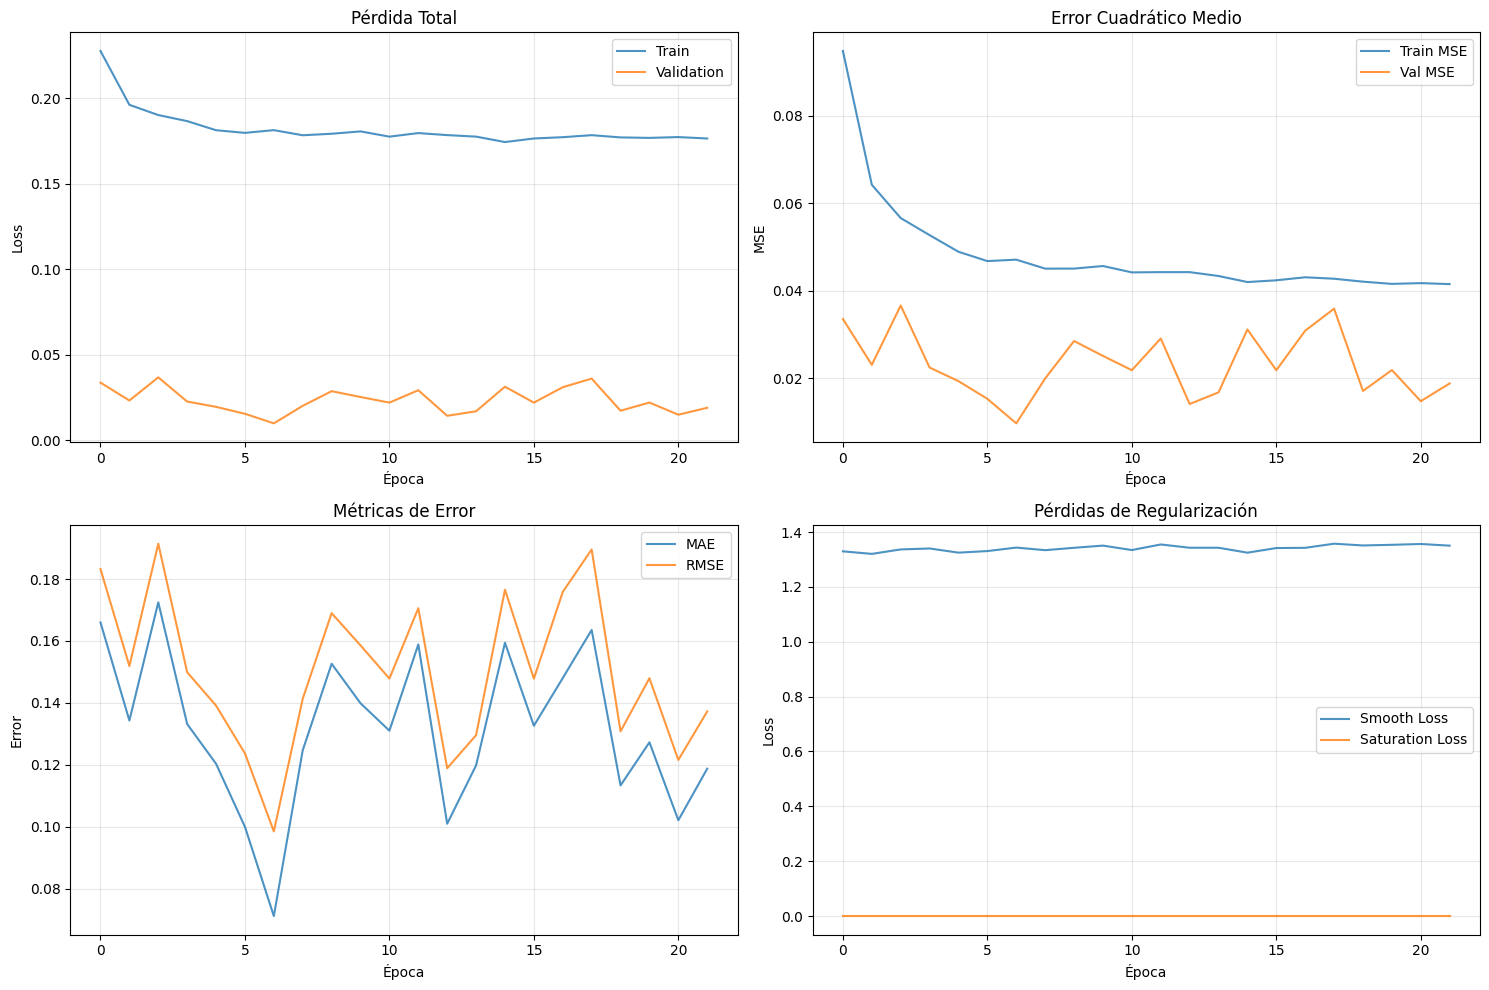

🔍 Evaluando controlador en datos de test...
📊 Resultados de evaluación:
   Test Loss: 0.033588
   MAE: 0.135325
   RMSE: 0.183017
   MAPE: 16.90%
   R² Score: 0.9645


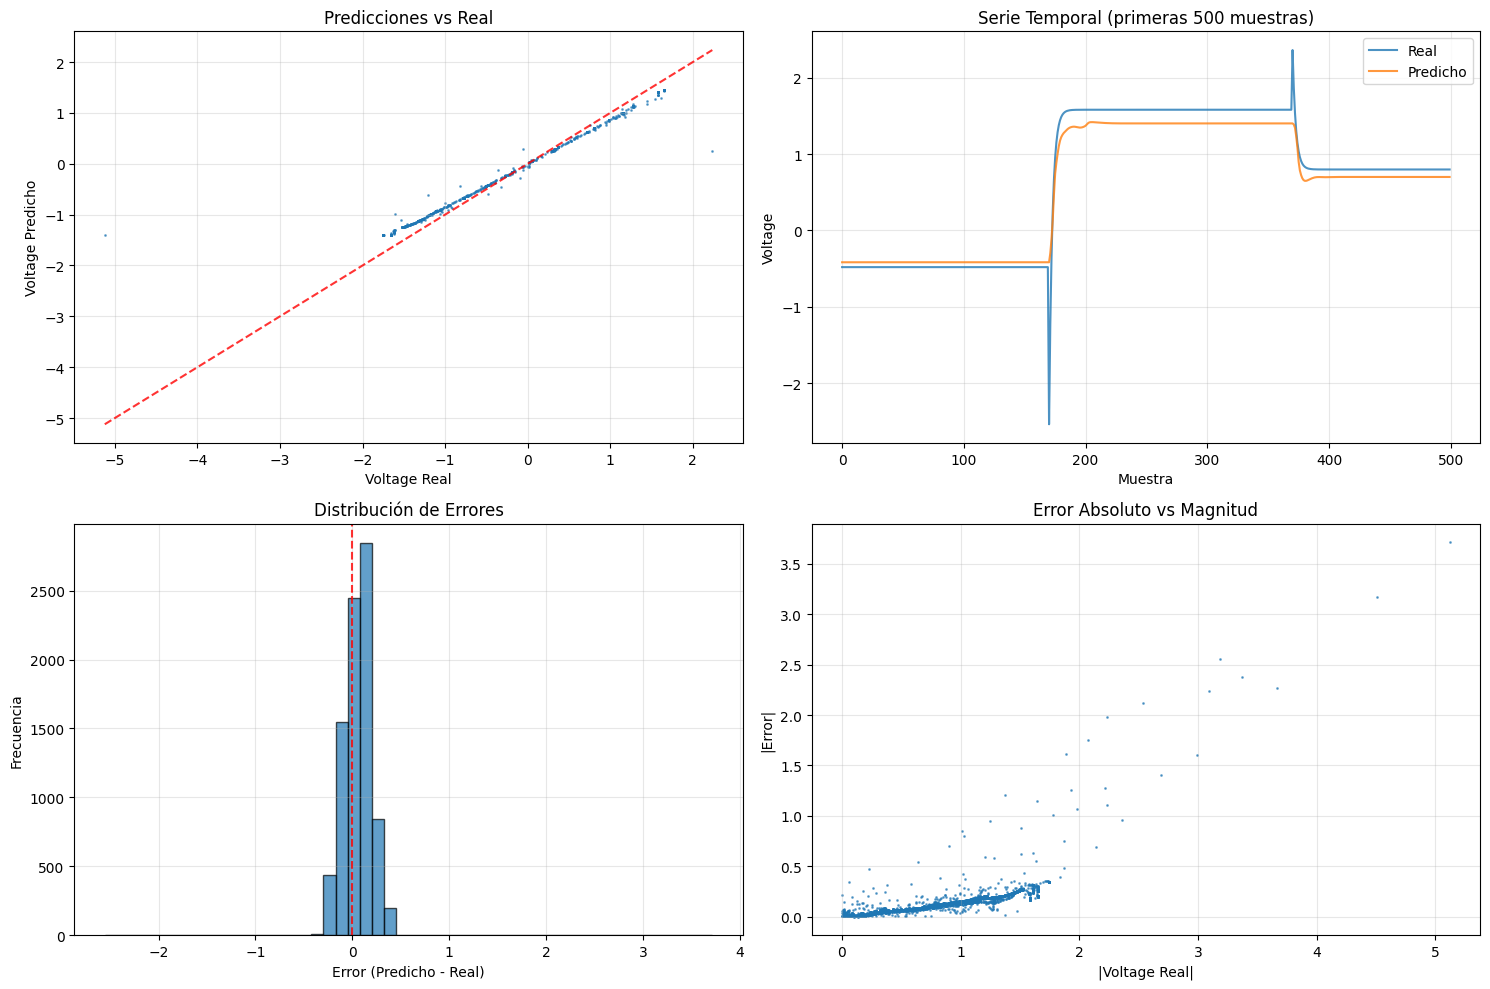

In [59]:
# Cargar datos procesados
processed_data = load_processed_data('processed_maglev_controller_data.pth')

# Entrenar con configuración por defecto
results = train_maglev_controller(processed_data)

=== LQR TRACKING - CONVERSIÓN MATLAB A PYTHON ===

Parámetros del sistema:
Punto de equilibrio a0 = 7.0 mm
Corriente de equilibrio i0 = 0.708 A

Ganancias LQR (precalculadas):
K = [-5154.6446, -137.7272, 30.9448]
Kr = -1016.256681

Iniciando simulación:
Método: Runge-Kutta 4to orden
Paso de tiempo: 0.005 s
Tiempo total: 20.0 s
Número de pasos: 4001


/tmp/ipykernel_52972/2652274166.py:88: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_sim[i] = Kr[0,0] * (ref_sim[i] - a0) - K @ x_sim[i]


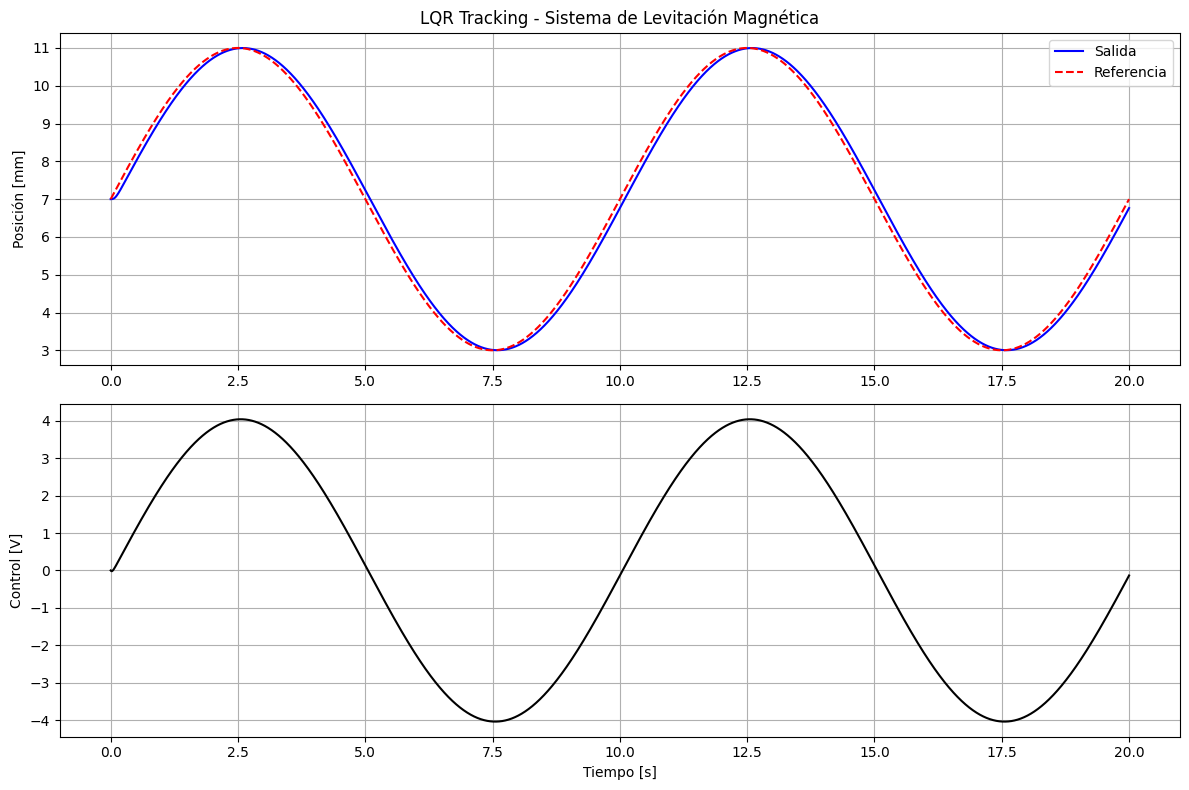


Error RMS: 0.167 mm

Estadísticas de la simulación:
Referencia: [3.0, 11.0] mm
Posición: [3.0, 11.0] mm
Control: [-4.0, 4.0] V
Error máximo: 0.237 mm


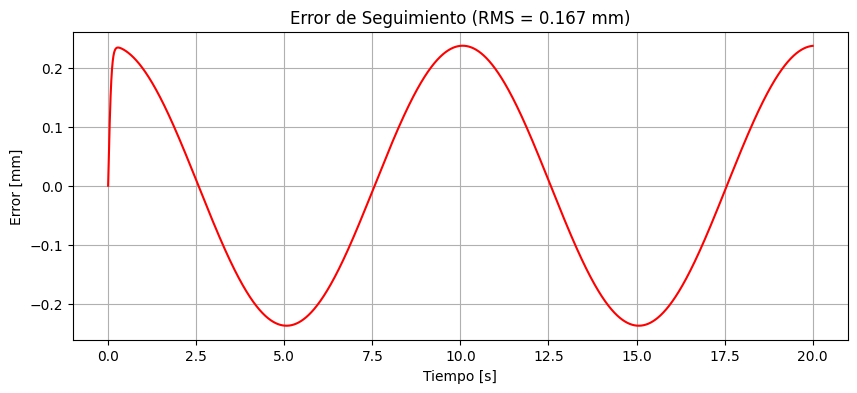


Verificación de estabilidad:
Eigenvalores del sistema en lazo cerrado:
  λ1 = -24.1938
  λ2 = -37.5332 ± 1.7873j
  λ3 = -37.5332 ± 1.7873j
Sistema estable: ✓


In [66]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# LQR TRACKING - IMPLEMENTACIÓN SIMPLIFICADA
print("=== LQR TRACKING - CONVERSIÓN MATLAB A PYTHON ===\n")

# 1. PARÁMETROS DEL SISTEMA
m = 0.068
Ke = 6.53e-5
R = 10
L = 0.4125
g = 9.81
a0 = 0.007
i0 = np.sqrt((m * g * a0**2) / Ke)

A = np.array([
    [0, 1, 0],
    [(Ke*i0**2)/(m*a0**3), 0, -(Ke*i0)/(m*a0**2)],
    [0, 0, -R/L]
])

B = np.array([[0], [0], [1/L]])
C = np.array([[1, 0, 0]])
D = 0

print("Parámetros del sistema:")
print(f"Punto de equilibrio a0 = {a0*1000:.1f} mm")
print(f"Corriente de equilibrio i0 = {i0:.3f} A")

# 2. GANANCIAS LQR PRECALCULADAS
K = np.array([[-5154.64457011539, -137.727154414640, 30.9448066898419]])
Kr = np.array([[-1016.25668098860]])

print(f"\nGanancias LQR (precalculadas):")
print(f"K = [{K[0,0]:.4f}, {K[0,1]:.4f}, {K[0,2]:.4f}]")
print(f"Kr = {Kr[0,0]:.6f}")

# 4. SIMULACIÓN
def ref_func(t):
    """Referencia senoidal ±4mm centrada en a0"""
    return a0 + 0.004 * np.sin(2*np.pi*0.1*t)

def system_dynamics(t, x):
    """Dinámicas del sistema en lazo cerrado"""
    ref = ref_func(t)
    u = Kr[0,0] * (ref - a0) - K @ x.reshape(-1, 1)
    dx = A @ x.reshape(-1, 1) + B * u[0,0]
    return dx.flatten()

# Parámetros de simulación
dt = 0.005  # Paso más pequeño para mejor precisión
tspan = np.arange(0, 20 + dt, dt)
x0 = np.array([0, 0, 0])

# Integración usando Runge-Kutta 4to orden
def rk4_step(f, t, x, dt):
    """Un paso de Runge-Kutta 4to orden"""
    k1 = f(t, x)
    k2 = f(t + dt/2, x + dt*k1/2)
    k3 = f(t + dt/2, x + dt*k2/2)
    k4 = f(t + dt, x + dt*k3)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6

# Inicializar arrays
n_steps = len(tspan)
x_sim = np.zeros((n_steps, 3))
x_sim[0] = x0

print(f"\nIniciando simulación:")
print(f"Método: Runge-Kutta 4to orden")
print(f"Paso de tiempo: {dt} s")
print(f"Tiempo total: {tspan[-1]} s")
print(f"Número de pasos: {n_steps}")

# Simulación principal
for i in range(n_steps - 1):
    x_sim[i+1] = rk4_step(system_dynamics, tspan[i], x_sim[i], dt)

# Calcular referencia y salida
ref_sim = np.array([ref_func(t) for t in tspan])
y_sim = (C @ x_sim.T).T.flatten() + a0

# Calcular control
u_sim = np.zeros(len(tspan))
for i in range(len(tspan)):
    u_sim[i] = Kr[0,0] * (ref_sim[i] - a0) - K @ x_sim[i]

# 5. GRÁFICAS
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(tspan, y_sim*1000, 'b-', linewidth=1.5, label='Salida')
plt.plot(tspan, ref_sim*1000, 'r--', linewidth=1.5, label='Referencia')
plt.ylabel('Posición [mm]')
plt.title('LQR Tracking - Sistema de Levitación Magnética')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(tspan, u_sim, 'k-', linewidth=1.5)
plt.ylabel('Control [V]')
plt.xlabel('Tiempo [s]')
plt.grid(True)

plt.tight_layout()
plt.show()

# 6. ERROR RMS
error_rms = np.sqrt(np.mean((ref_sim - y_sim)**2))
print(f"\nError RMS: {error_rms*1000:.3f} mm")

# Estadísticas adicionales
print(f"\nEstadísticas de la simulación:")
print(f"Referencia: [{np.min(ref_sim)*1000:.1f}, {np.max(ref_sim)*1000:.1f}] mm")
print(f"Posición: [{np.min(y_sim)*1000:.1f}, {np.max(y_sim)*1000:.1f}] mm")
print(f"Control: [{np.min(u_sim):.1f}, {np.max(u_sim):.1f}] V")
print(f"Error máximo: {np.max(np.abs(ref_sim - y_sim))*1000:.3f} mm")

# Gráfica del error
plt.figure(figsize=(10, 4))
plt.plot(tspan, (ref_sim - y_sim)*1000, 'r-', linewidth=1.5)
plt.ylabel('Error [mm]')
plt.xlabel('Tiempo [s]')
plt.title(f'Error de Seguimiento (RMS = {error_rms*1000:.3f} mm)')
plt.grid(True)
plt.show()

# Verificar estabilidad
eigenvalues = np.linalg.eigvals(A - B @ K)
print(f"\nVerificación de estabilidad:")
print(f"Eigenvalores del sistema en lazo cerrado:")
for i, eig in enumerate(eigenvalues):
    if np.isreal(eig):
        print(f"  λ{i+1} = {eig.real:.4f}")
    else:
        print(f"  λ{i+1} = {eig.real:.4f} ± {abs(eig.imag):.4f}j")

all_stable = np.all(np.real(eigenvalues) < 0)
print(f"Sistema estable: {'✓' if all_stable else '✗'}")

## RNN controller

In [68]:
class RNNController:
    """Controlador RNN que maneja la normalización automáticamente"""
    
    def __init__(self, model, scaler, seq_length=30, device='cpu'):
        self.model = model
        self.scaler = scaler
        self.seq_length = seq_length
        self.device = device
        
        # Buffer para secuencias temporales (normalizado)
        self.history_buffer = np.zeros((seq_length, 4))  # [pos, vel, current, ref]
        self.buffer_initialized = False
        
    def reset(self):
        """Resetea el buffer temporal"""
        self.history_buffer = np.zeros((self.seq_length, 4))
        self.buffer_initialized = False
        print("🔄 Buffer RNN reseteado")
    
    def predict_control(self, position, velocity, current, reference):
        """
        Predice voltaje de control usando RNN
        
        Args:
            position: posición actual [m] - VALOR FÍSICO
            velocity: velocidad actual [m/s] - VALOR FÍSICO  
            current: corriente actual [A] - VALOR FÍSICO
            reference: referencia [m] - VALOR FÍSICO
            
        Returns:
            voltage: voltaje de control [V] - VALOR FÍSICO
        """
        
        # 1. NORMALIZAR: Convertir valores físicos a normalizados
        physical_state = np.array([position, velocity, current, reference, 0.0])  # dummy voltage
        normalized_state = self.scaler.transform(physical_state.reshape(1, -1))[0]
        normalized_input = normalized_state[:4]  # solo input features
        
        # 2. ACTUALIZAR BUFFER TEMPORAL
        if not self.buffer_initialized:
            # Primera vez: llenar buffer completo
            self.history_buffer[:] = normalized_input
            self.buffer_initialized = True
        else:
            # Shift temporal + agregar nuevo estado
            self.history_buffer[:-1] = self.history_buffer[1:]
            self.history_buffer[-1] = normalized_input
        
        # 3. PREDICCIÓN RNN (en espacio normalizado)
        input_tensor = torch.FloatTensor(self.history_buffer).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            voltage_normalized, _ = self.model(input_tensor)
            voltage_normalized = voltage_normalized.cpu().numpy()[0, 0]
        
        # 4. DESNORMALIZAR: Convertir voltaje a valor físico
        full_normalized = np.array([*normalized_input, voltage_normalized])
        full_physical = self.scaler.inverse_transform(full_normalized.reshape(1, -1))[0]
        voltage_physical = full_physical[4]
        
        return voltage_physical

## Compare LQR vs RNN

In [69]:
def run_comparative_simulation():
    """
    Ejecuta simulación comparando LQR vs RNN en el mismo sistema
    """
    
    print("🚀 SIMULACIÓN COMPARATIVA: LQR vs RNN")
    print("="*50)
    
    # PARÁMETROS DEL SISTEMA (iguales que tu código LQR)
    m = 0.068
    Ke = 6.53e-5
    R = 10
    L = 0.4125
    g = 9.81
    a0 = 0.007
    i0 = np.sqrt((m * g * a0**2) / Ke)
    
    A = np.array([
        [0, 1, 0],
        [(Ke*i0**2)/(m*a0**3), 0, -(Ke*i0)/(m*a0**2)],
        [0, 0, -R/L]
    ])
    
    B = np.array([[0], [0], [1/L]])
    C = np.array([[1, 0, 0]])
    
    # GANANCIAS LQR (las mismas que tienes)
    K = np.array([[-5154.64457011539, -137.727154414640, 30.9448066898419]])
    Kr = np.array([[-1016.25668098860]])
    
    print(f"✅ Sistema configurado:")
    print(f"   Punto equilibrio: {a0*1000:.1f} mm")
    print(f"   Corriente equilibrio: {i0:.3f} A")
    
    # CARGAR CONTROLADOR RNN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    rnn_model, scaler = load_rnn_controller(device=device)
    
    if rnn_model is None or scaler is None:
        print("❌ No se pudo cargar el controlador RNN")
        print("   Ejecutando solo simulación LQR...")
        rnn_controller = None
    else:
        rnn_controller = RNNController(rnn_model, scaler, device=device)
        print("✅ Controlador RNN listo")
    
    # FUNCIÓN DE REFERENCIA (la misma que usaste)
    def ref_func(t):
        """Referencia senoidal ±4mm centrada en a0"""
        return a0 + 0.004 * np.sin(2*np.pi*0.1*t)
    
    # DINÁMICAS DEL SISTEMA
    def system_dynamics_lqr(t, x):
        """Dinámicas con controlador LQR"""
        ref = ref_func(t)
        u = Kr[0,0] * (ref - a0) - K @ x.reshape(-1, 1)
        dx = A @ x.reshape(-1, 1) + B * u[0,0]
        return dx.flatten()
    
    def system_dynamics_rnn(t, x, position_abs):
        """Dinámicas con controlador RNN"""
        ref = ref_func(t)
        # RNN necesita estado absoluto
        velocity = x[1]
        current = x[2]
        u = rnn_controller.predict_control(position_abs, velocity, current, ref)
        dx = A @ x.reshape(-1, 1) + B * u
        return dx.flatten(), u
    
    # INTEGRACIÓN RUNGE-KUTTA 4TO ORDEN
    def rk4_step(f, t, x, dt, is_rnn=False):
        """Un paso de Runge-Kutta 4to orden"""
        if is_rnn:
            position_abs = x[0] + a0  # Convertir a posición absoluta
            k1, u1 = f(t, x, position_abs)
            k2, u2 = f(t + dt/2, x + dt*k1/2, position_abs + dt*k1[0]/2)
            k3, u3 = f(t + dt/2, x + dt*k2/2, position_abs + dt*k2[0]/2)
            k4, u4 = f(t + dt, x + dt*k3, position_abs + dt*k3[0])
            x_new = x + dt*(k1 + 2*k2 + 2*k3 + k4)/6
            u_avg = (u1 + 2*u2 + 2*u3 + u4)/6  # Promedio del control
            return x_new, u_avg
        else:
            k1 = f(t, x)
            k2 = f(t + dt/2, x + dt*k1/2)
            k3 = f(t + dt/2, x + dt*k2/2)
            k4 = f(t + dt, x + dt*k3)
            return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    
    # PARÁMETROS DE SIMULACIÓN
    dt = 0.005
    tspan = np.arange(0, 20 + dt, dt)
    x0 = np.array([0, 0, 0])  # Estado inicial (desviaciones del equilibrio)
    n_steps = len(tspan)
    
    print(f"\n🔄 Ejecutando simulaciones:")
    print(f"   Tiempo total: {tspan[-1]} s")
    print(f"   Paso: {dt} s")
    print(f"   Puntos: {n_steps}")
    
    # SIMULACIÓN LQR
    print("   📊 Simulando LQR...")
    x_lqr = np.zeros((n_steps, 3))
    x_lqr[0] = x0
    u_lqr = np.zeros(n_steps)
    
    for i in range(n_steps - 1):
        x_lqr[i+1] = rk4_step(system_dynamics_lqr, tspan[i], x_lqr[i], dt)
        # Calcular control LQR
        ref = ref_func(tspan[i])
        u_lqr[i] = Kr[0,0] * (ref - a0) - K @ x_lqr[i]
    u_lqr[-1] = u_lqr[-2]  # Último punto
    
    # SIMULACIÓN RNN (si está disponible)
    if rnn_controller is not None:
        print("   🧠 Simulando RNN...")
        rnn_controller.reset()  # Resetear buffer
        
        x_rnn = np.zeros((n_steps, 3))
        x_rnn[0] = x0
        u_rnn = np.zeros(n_steps)
        
        for i in range(n_steps - 1):
            x_rnn[i+1], u_rnn[i] = rk4_step(system_dynamics_rnn, tspan[i], x_rnn[i], dt, is_rnn=True)
        u_rnn[-1] = u_rnn[-2]  # Último punto
    else:
        x_rnn, u_rnn = None, None
    
    # CALCULAR SALIDAS Y REFERENCIA
    ref_sim = np.array([ref_func(t) for t in tspan])
    y_lqr = (C @ x_lqr.T).T.flatten() + a0  # Posición absoluta
    
    if x_rnn is not None:
        y_rnn = (C @ x_rnn.T).T.flatten() + a0
    else:
        y_rnn = None
    
    # MÉTRICAS DE DESEMPEÑO
    error_lqr = np.sqrt(np.mean((ref_sim - y_lqr)**2))
    print(f"\n📊 RESULTADOS:")
    print(f"   LQR RMSE: {error_lqr*1000:.3f} mm")
    
    if y_rnn is not None:
        error_rnn = np.sqrt(np.mean((ref_sim - y_rnn)**2))
        print(f"   RNN RMSE: {error_rnn*1000:.3f} mm")
        improvement = ((error_lqr - error_rnn) / error_lqr) * 100
        print(f"   Mejora RNN: {improvement:.1f}%")
    
    # GUARDAR DATOS
    results = {
        'time': tspan,
        'reference': ref_sim,
        'lqr_position': y_lqr,
        'lqr_voltage': u_lqr,
        'lqr_states': x_lqr
    }
    
    if y_rnn is not None:
        results.update({
            'rnn_position': y_rnn,
            'rnn_voltage': u_rnn,
            'rnn_states': x_rnn
        })
    
    return results

In [70]:
def plot_comparison_results(results):
    """Grafica comparación LQR vs RNN"""
    
    time = results['time']
    has_rnn = 'rnn_position' in results
    
    if has_rnn:
        fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    else:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Posiciones
    axes[0].plot(time, results['reference']*1000, 'k--', linewidth=2, 
                label='Referencia', alpha=0.8)
    axes[0].plot(time, results['lqr_position']*1000, 'b-', linewidth=1.5, 
                label='LQR', alpha=0.8)
    
    if has_rnn:
        axes[0].plot(time, results['rnn_position']*1000, 'r-', linewidth=1.5, 
                    label='RNN', alpha=0.8)
    
    axes[0].set_ylabel('Posición [mm]')
    axes[0].set_title('Comparación de Controladores - Levitador Magnético')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Voltajes de control
    axes[1].plot(time, results['lqr_voltage'], 'b-', linewidth=1.5, 
                label='LQR', alpha=0.8)
    
    if has_rnn:
        axes[1].plot(time, results['rnn_voltage'], 'r-', linewidth=1.5, 
                    label='RNN', alpha=0.8)
    
    axes[1].set_ylabel('Voltaje [V]')
    axes[1].set_title('Señales de Control')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    if not has_rnn:
        axes[1].set_xlabel('Tiempo [s]')
    
    # Errores (solo si hay RNN)
    if has_rnn:
        error_lqr = (results['lqr_position'] - results['reference']) * 1000
        error_rnn = (results['rnn_position'] - results['reference']) * 1000
        
        axes[2].plot(time, error_lqr, 'b-', linewidth=1.5, 
                    label=f'LQR (RMSE: {np.sqrt(np.mean(error_lqr**2)):.2f}mm)', alpha=0.8)
        axes[2].plot(time, error_rnn, 'r-', linewidth=1.5, 
                    label=f'RNN (RMSE: {np.sqrt(np.mean(error_rnn**2)):.2f}mm)', alpha=0.8)
        axes[2].axhline(0, color='k', linestyle='--', alpha=0.5)
        axes[2].set_ylabel('Error [mm]')
        axes[2].set_xlabel('Tiempo [s]')
        axes[2].set_title('Errores de Seguimiento')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas adicionales
    print(f"\n📈 ESTADÍSTICAS ADICIONALES:")
    print(f"   Referencia: [{np.min(results['reference'])*1000:.1f}, {np.max(results['reference'])*1000:.1f}] mm")
    print(f"   LQR control: [{np.min(results['lqr_voltage']):.1f}, {np.max(results['lqr_voltage']):.1f}] V")
    
    if has_rnn:
        print(f"   RNN control: [{np.min(results['rnn_voltage']):.1f}, {np.max(results['rnn_voltage']):.1f}] V")


🎯 COMPARACIÓN LQR vs RNN - LEVITADOR MAGNÉTICO
🚀 SIMULACIÓN COMPARATIVA: LQR vs RNN
✅ Sistema configurado:
   Punto equilibrio: 7.0 mm
   Corriente equilibrio: 0.708 A
🔧 Cargando controlador RNN entrenado...
✅ Scaler cargado: ['position', 'velocity', 'current', 'reference'] → voltage
   Media del scaler: [ 7.11017287e-03 -5.24283812e-05  1.11308162e-02  7.10544012e-03
  1.09085978e-01]
   Escala del scaler: [3.29703690e-03 9.25039489e-03 3.35171916e-01 3.34759914e-03
 3.38860511e+00]
✅ Modelo RNN cargado desde época 6
   Mejor val loss: 0.009867
✅ Controlador RNN listo

🔄 Ejecutando simulaciones:
   Tiempo total: 20.0 s
   Paso: 0.005 s
   Puntos: 4001
   📊 Simulando LQR...
   🧠 Simulando RNN...
🔄 Buffer RNN reseteado


/tmp/ipykernel_52972/3447458941.py:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_lqr[i] = Kr[0,0] * (ref - a0) - K @ x_lqr[i]



📊 RESULTADOS:
   LQR RMSE: 0.167 mm
   RNN RMSE: nan mm
   Mejora RNN: nan%


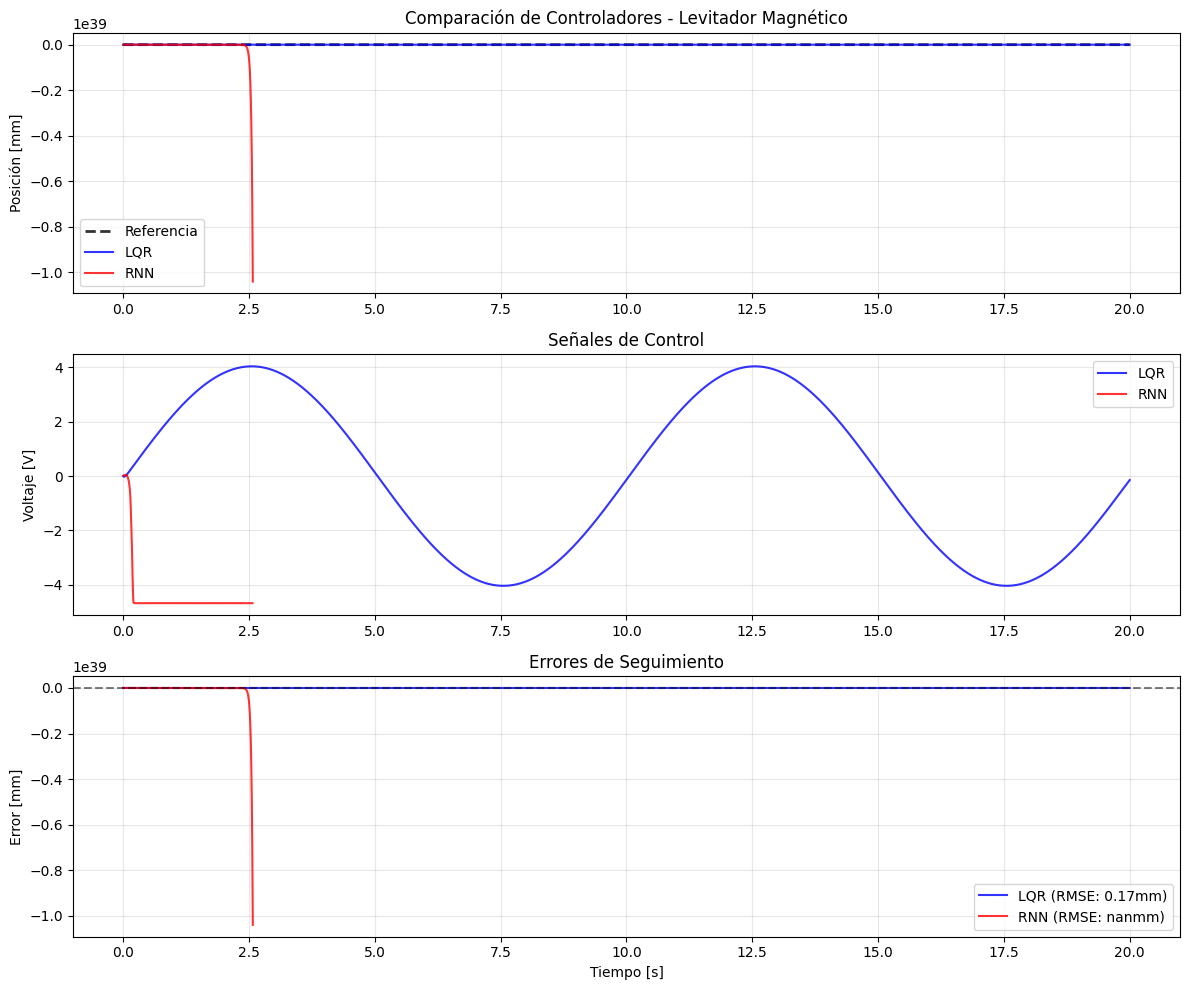


📈 ESTADÍSTICAS ADICIONALES:
   Referencia: [3.0, 11.0] mm
   LQR control: [-4.0, 4.0] V
   RNN control: [nan, nan] V
✅ Resultados guardados en: lqr_vs_rnn_comparison.csv

🏁 Comparación completada!


In [84]:
def main():
    """Función principal para ejecutar la comparación"""
    
    print("🎯 COMPARACIÓN LQR vs RNN - LEVITADOR MAGNÉTICO")
    print("="*60)
    
    # Ejecutar simulación comparativa
    results = run_comparative_simulation()
    
    # Visualizar resultados
    plot_comparison_results(results)
    
    # Guardar datos para análisis posterior
    if 'rnn_position' in results:
        df = pd.DataFrame({
            'time': results['time'],
            'reference': results['reference'],
            'lqr_position': results['lqr_position'],
            'lqr_voltage': results['lqr_voltage'],
            'rnn_position': results['rnn_position'],
            'rnn_voltage': results['rnn_voltage']
        })
        df.to_csv('lqr_vs_rnn_comparison.csv', index=False)
        print(f"✅ Resultados guardados en: lqr_vs_rnn_comparison.csv")
    
    print("\n🏁 Comparación completada!")

if __name__ == "__main__":
    main()